# 11_05: A taste of machine learning

In [1]:
import math
import collections
import dataclasses
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

If you're learning about data analysis, there's a good chance you're thinking about big data and machine learning. It's a technology of huge importance to the world today, and it's also a huge subject, covered by many excellent courses in the LinkedIn library. So all I want to do is to give you a small taste of it, using the tools we have discussed, plus the very comprehensive scikit-learn library.

The name "machine learning" is very descriptive. [slide] It's the science of getting computers to learn from data. We have already seen the standard modus operandi of machine learning: divide your dataset into training data and testing data; use the former to train a model or algorithm; then use the testing data to verify performance.

Machine learning covers many different tasks and use cases. [slide] Perhaps the most straightforward is _classification_: we teach an algorithm to assign an input to one of a few predefined classes, by providing a number of examples (inputs with their labels). The algorithm then will provide classes for unlabeled examples.

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Once more, we will use our gapminder data, and pick a year. We'll try to answer a simple enough question. Can we tell the continent of a country just by looking at the macro variables of population, life_expectancy, child survival, babies_per_woman, and gdp?

In [2]:
gm = pd.read_csv('gapminder2.csv')

In [79]:
gm2023 = gm[gm.year == 2023]
gm2023.head()

,country,year,region,population,life_expectancy,age5_surviving,babies_per_woman,gdp_per_capita
207,Afghanistan,2023,Asia,41500000.0,64.0,94.760,4.84,1400.0
431,Albania,2023,Europe,2810000.0,77.3,99.199,1.35,16100.0
655,Algeria,2023,Africa,46200000.0,77.1,97.960,2.77,11400.0
866,Andorra,2023,Europe,80900.0,82.9,99.723,1.08,55700.0
1090,Angola,2023,Africa,36700000.0,65.9,93.300,5.12,5810.0


We collect these explanatory variables into a pandas dataframe, and the response variable, which is our **class label** into a series. We'll want the series to be categorical...

In [83]:
x = gm2023[['population', 'life_expectancy', 'age5_surviving', 'babies_per_woman', 'gdp_per_capita']]

In [84]:
y = gm2023['region'].astype('category')

...so we can turn it into numerical codes, as needed by the scikit-learn algorithm.

In [87]:
z = y.cat.codes
z.head()

207     2
431     3
655     0
866     3
1090    0
dtype: int8

scikit-learn usefully provides a function to divide a dataset into training and testing.

In [71]:
x_train, x_test, z_train, z_test = train_test_split(x, z, test_size=0.3)

In [108]:
tree = DecisionTreeClassifier()

We'll start with a **decision tree** classifier. This is an algorithm that splits data into branches based on the explanatory variables, creating a tree-like model of decisions. Here's an example to distinguish between breeds of dogs. At each node we are making a decision based on a variable, and follow different branches based on that, until we find a leaf that matches the input to a class.

The point to machine learning, however, is that we don't know what decisions to make, and we have to learn them from examples. [slide] So we start processing example inputs through an initial tree, and then the algorithm modifies the tree by comparing the predicted labels with the known example labels.

[slide] After going through the example datasets, possibly multiple times, the classifier is trained, and we can use it for _inference_---on inputs that do not have labels.

So let's train our tree... it's very fast.

In [109]:
tree.fit(x_train, z_train)

DecisionTreeClassifier()

And let's use it to assign labels to our test examples.

In [168]:
tree_pred = tree.predict(x_test)
tree_pred

array([2, 3, 0, 3, 3, 3, 0, 3, 0, 0, 2, 3, 2, 2, 3, 2, 0, 0, 0, 2, 0, 3,
       0, 3, 4, 2, 2, 1, 1, 2, 3, 2, 1, 0, 3, 0, 2, 1, 3, 1, 0, 0, 0, 0,
       1, 2, 3, 0, 2, 0, 3, 0, 0, 0, 0, 0, 3, 0, 3], dtype=int8)

These are integer numbers, but we can match them back to categories. Let's see how we did. Several predictions are indeed correct, but some are wrong.

In [169]:
pd.DataFrame({'label': y.cat.categories[z_test],
              'predicted': y.cat.categories[tree_pred]}).head(20)

,label,predicted
0,Asia,Asia
1,Asia,Europe
2,Africa,Africa
3,Europe,Europe
4,Europe,Europe
5,Europe,Europe
6,Africa,Africa
7,Europe,Europe
8,Asia,Africa
9,Africa,Africa


In fact, scikit-learn tells us about 64% of the predictions are correct.

In [174]:
accuracy_score(z_test, tree_pred)

0.6440677966101694

We could have computed this ourselves!

In [175]:
np.sum(y.cat.categories[z_test] == y.cat.categories[tree_pred]) / len(z_test)

0.6440677966101694

scikit-learn can give us a much more detailed report, which answers questions that may be important in practical use cases. Let's look at Africa to explain.

* The _precision_ number says that out of all the times the classifier chose "Africa", 70% were correct.
* The _recall_ says that out of all the examples from Africa, 89% were correctly identified.
* The f1 score is an average of these two.
* The support is the number of test-dataset examples from Africa.
* Finally, the averages at the bottom are taken across classes without weights and by weighting for the number of examples in each class.

In [176]:
print(classification_report(z_test, tree_pred, target_names=y.cat.categories))

              precision    recall  f1-score   support

      Africa       0.70      0.89      0.78        18
     America       0.83      0.45      0.59        11
        Asia       0.46      0.46      0.46        13
      Europe       0.62      0.91      0.74        11
     Oceania       1.00      0.17      0.29         6

    accuracy                           0.64        59
   macro avg       0.72      0.58      0.57        59
weighted avg       0.69      0.64      0.62        59



We can also plot the _confusion matrix_ showing which true labels (the rows) ended up in which estimated class. We see that the classifier did OK with Africa and Europe input, but it found it hard to distinguish between America and Asia. Also some countries in Asia and Oceania ended up classified into Africa.

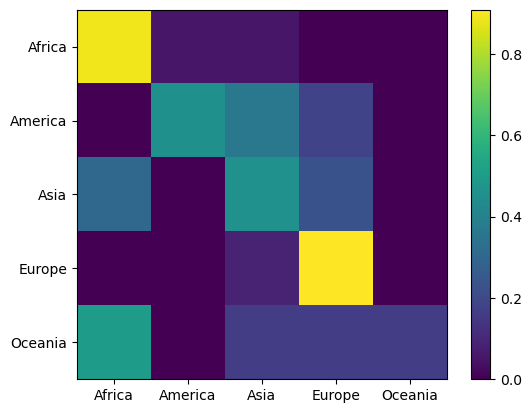

In [178]:
pp.imshow(confusion_matrix(z_test, tree_pred, normalize='true'))
pp.xticks(range(5), y.cat.categories); pp.yticks(range(5), y.cat.categories)
pp.colorbar();

Can we do better? There are many classification algorithms of various degrees of sophistication. One step up from a tree, we get a random forest, which combines multiple decision trees to improve classification accuracy and control overfitting. The algorithm builds multiple trees during training and uses voting or averages to combine their outputs during inference. In scikit-learn, we only have to change the definition of the model.

In [158]:
forest = RandomForestClassifier()

In [159]:
forest.fit(x_train, z_train)

RandomForestClassifier()

In [179]:
forest_pred = forest.predict(x_test)

So the accuracy went up a few percent, but the confusion matrix is similar. This is probably a limitation of the data themselves. People can thrive (or fail to) in different places on Earth.

In [181]:
print(classification_report(z_test, forest_pred, target_names=y.cat.categories))

              precision    recall  f1-score   support

      Africa       0.75      0.83      0.79        18
     America       0.50      0.27      0.35        11
        Asia       0.62      0.77      0.69        13
      Europe       0.69      1.00      0.81        11
     Oceania       1.00      0.17      0.29         6

    accuracy                           0.68        59
   macro avg       0.71      0.61      0.59        59
weighted avg       0.69      0.68      0.64        59



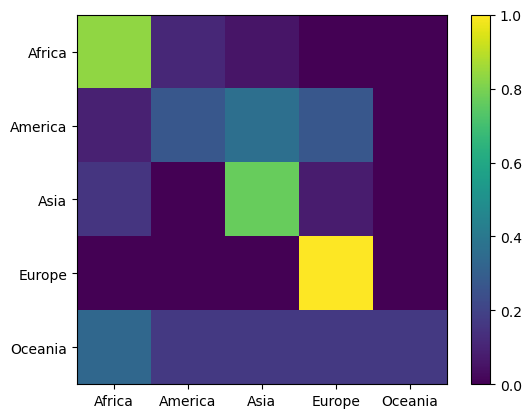

In [182]:
pp.imshow(confusion_matrix(z_test, forest_pred, normalize='true'))
pp.xticks(range(5), y.cat.categories); pp.yticks(range(5), y.cat.categories)
pp.colorbar();

This completes our appetizer of machine learning. It's a fascinating discipline and I know that if you are interested you will find many excellent resources on linkedin learning, in the literature, and on websites.